# Twitter Sentiment Analysis with BERT

In [4]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import emoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

In [5]:
#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
 

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<Figure size 640x480 with 0 Axes>

# Loading the data

In [8]:
df = pd.read_csv(r"C:\Users\SSS\Downloads\Corona_NLP_train.csv\Corona_NLP_train.csv",encoding='ISO-8859-1')
df_test = pd.read_csv(r"C:\Users\SSS\Downloads\Corona_NLP_test.csv")

In [9]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


# Convert the date column 'TweetAt' to pandas datetime format to improve its usability in the further analysis.

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
df['TweetAt'] = pd.to_datetime(df['TweetAt'])

# Duplicate tweets

In [14]:
df.drop_duplicates(subset='OriginalTweet',inplace=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       41157 non-null  int64         
 1   ScreenName     41157 non-null  int64         
 2   Location       32567 non-null  object        
 3   TweetAt        41157 non-null  datetime64[ns]
 4   OriginalTweet  41157 non-null  object        
 5   Sentiment      41157 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 2.2+ MB


In [ ]:
# No Duplicate Tweets

# Data Visualization

In [ ]:
# Tweets count by date

In [16]:
tweets_per_day = df['TweetAt'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name='counts')

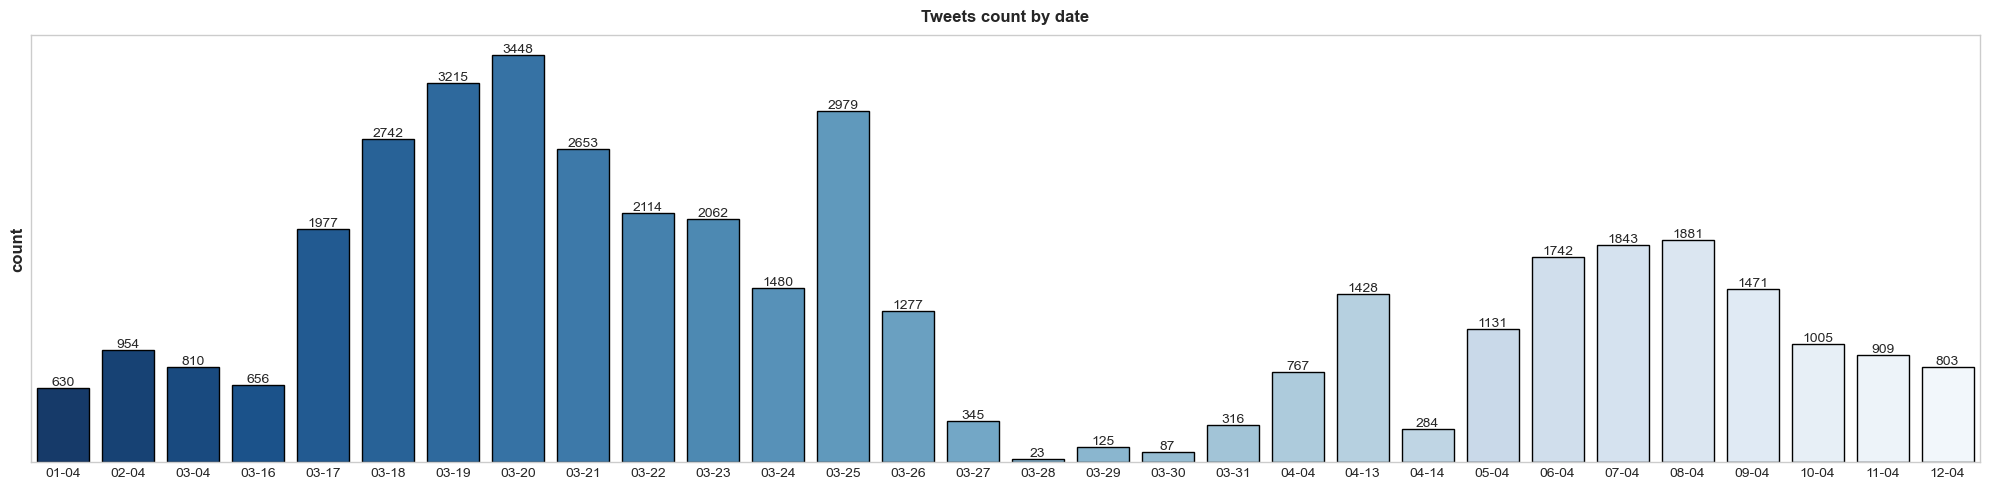

In [17]:
plt.figure(figsize=(20,5))
ax = sns.barplot(x='index', y='counts', data=tweets_per_day,edgecolor = 'black',ci=False, palette='Blues_r')#ci=confidence interval
plt.title('Tweets count by date')
plt.yticks([])
ax.bar_label(ax.containers[0])  #Container with all the bars and optionally errorbars, likely returned from bar or barh.
plt.ylabel('count')
plt.xlabel('')
plt.show()

We notice that in the dataset there are some days without tweets in the dataset. Among the days with tweets, most of them are made around the end of March: from 18th of March to the 26th of March.

In [ ]:
# Tweets per country and city

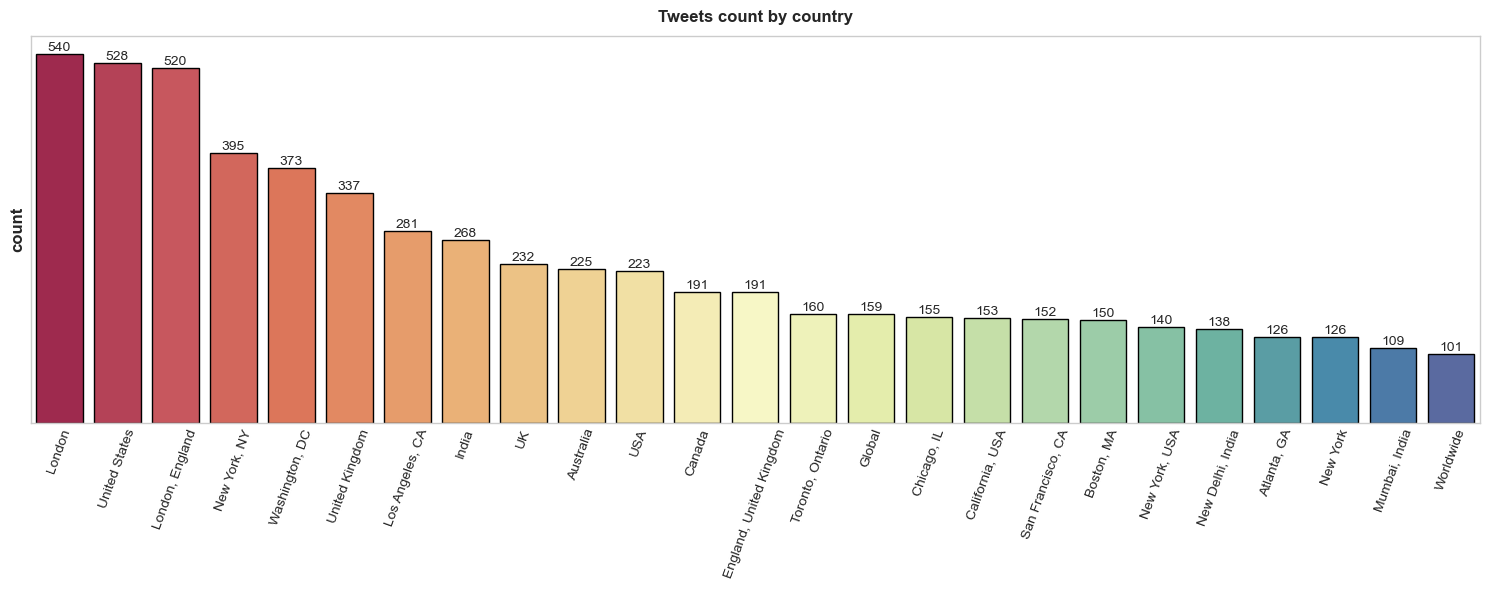

In [18]:
tweets_per_country = df['Location'].value_counts().loc[lambda x : x > 100].reset_index(name='counts')
plt.figure(figsize=(15,6))
ax = sns.barplot(x='index', y='counts', data=tweets_per_country,edgecolor = 'black',ci=False, palette='Spectral')
plt.title('Tweets count by country')
plt.xticks(rotation=70)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

The 'location' column contains both countries and cities. It could be interesting to separate cities and countries, however this wont be investigated in this work.

# Tweets Deep Cleaning

In [19]:
df = df[['OriginalTweet','Sentiment']]

In [20]:
df_test = df_test[['OriginalTweet','Sentiment']]

In [29]:
import nltk 
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import PorterStemmer,LancasterStemmer,SnowballStemmer,WordNetLemmatizer
from nltk.corpus import stopwords

In [30]:
stp=stopwords.words("english")    # default language-urdu
stp.remove("not")

In [31]:
"not" in stp

False

In [32]:
new_l=[]
for sent in df["OriginalTweet"]:
    l=[]
    ls=sent.lower()
    ls=re.sub("<.*?>"," ",ls)
    ls=re.sub("https://\S*","",ls)
    ls=re.sub("[^a-zA-Z ]","",ls)
    
    for word in word_tokenize(ls):
        if word in stp or len(word)<=2:
            pass
        else:
            lm=WordNetLemmatizer().lemmatize(word)
            l.append(lm)
    new_l.append(" ".join(l))        
text_new=pd.DataFrame({"Cleaned_tweet":new_l}) 
text_new

,Cleaned_tweet
0,menyrbie philgahan chrisitv
1,advice talk neighbour family exchange phone nu...
2,coronavirus australia woolworth give elderly d...
3,food stock not one emptyplease dont panic enou...
4,ready supermarket covid outbreaknot paranoid f...
...,...
41152,airline pilot offering stock supermarket shelf...
41153,response complaint not provided citing covid r...
41154,know getting tough kameronwilds rationing toil...
41155,wrong smell hand sanitizer starting turn oncor...


In [33]:
new_l=[]
for sent in df_test["OriginalTweet"]:
    l=[]
    ls=sent.lower()
    ls=re.sub("<.*?>"," ",ls)
    ls=re.sub("https://\S*","",ls)
    ls=re.sub("[^a-zA-Z ]","",ls)
    
    for word in word_tokenize(ls):
        if word in stp or len(word)<=2:
            pass
        else:
            lm=WordNetLemmatizer().lemmatize(word)
            l.append(lm)
    new_l.append(" ".join(l))        
text_new_test=pd.DataFrame({"Cleaned_tweet_test":new_l}) 
text_new_test

,Cleaned_tweet_test
0,trending new yorkers encounter empty supermark...
1,couldnt find hand sanitizer fred meyer turned ...
2,find protect loved one coronavirus
3,panic buying hit newyork city anxious shopper ...
4,toiletpaper dunnypaper coronavirus coronavirus...
...,...
3793,meanwhile supermarket israel people dance sing...
3794,panic buy lot nonperishable item echo need foo...
3795,asst prof economics cconces nbcphiladelphia ta...
3796,gov need somethings instead biar rakyat assume...


In [35]:
df['text_clean'] = text_new
df_test['text_clean'] = text_new_test

In [36]:
df['text_clean'].head()

0                          menyrbie philgahan chrisitv
1    advice talk neighbour family exchange phone nu...
2    coronavirus australia woolworth give elderly d...
3    food stock not one emptyplease dont panic enou...
4    ready supermarket covid outbreaknot paranoid f...
Name: text_clean, dtype: object

In [37]:
df_test['text_clean'].head()

0    trending new yorkers encounter empty supermark...
1    couldnt find hand sanitizer fred meyer turned ...
2                   find protect loved one coronavirus
3    panic buying hit newyork city anxious shopper ...
4    toiletpaper dunnypaper coronavirus coronavirus...
Name: text_clean, dtype: object

In [38]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [39]:
df['text_len'] = text_len

In [40]:
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

In [41]:
df_test['text_len'] = text_len_test

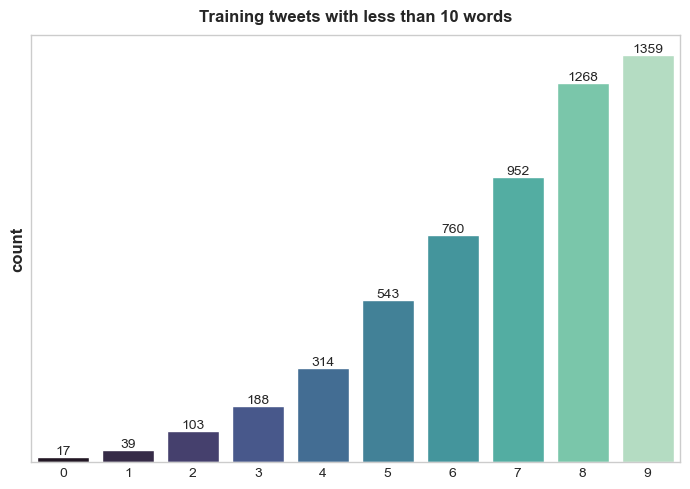

In [42]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

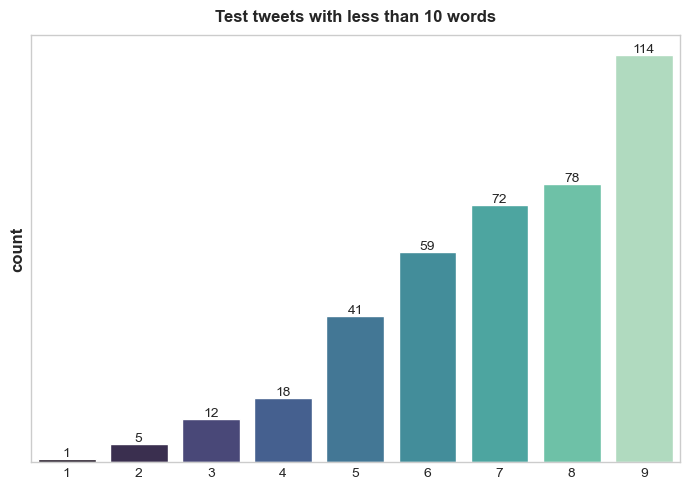

In [43]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')
plt.title('Test tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

As we can see, there are lots of cleaned tweets with 0 words: this is due to the cleaning performed before. This means that some tweets contained only mentions, hashtags and links, which have been removed. We will drop these empty tweets and also those with less than 5 words.

In [44]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (41157, 4)
 DF TEST SHAPE: (3798, 4)


In [45]:
df = df[df['text_len'] > 4]

In [46]:
df_test = df_test[df_test['text_len'] > 4]

In [47]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (40496, 4)
 DF TEST SHAPE: (3762, 4)


Training data deeper cleaning

Let's perform a further cleaning checking the tokenizer version of the sentences.

First, we import the BERT tokenizer.

In [48]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased') # to use pretrained tokenizer

In [49]:
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True) # tokenizer class will tokenize the raw input and add special tokens
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)

In [50]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 89


Let's check the long tokenized sentences (with more than 80 tokens ):

In [51]:
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}") 

INDEX: 1608, TEXT: zsah policie proti spekulantm roukami popud hejtman steckho kraje spoluprci policiecz podle krizovho zkona zajistil tisrouek firmy kter mla dodat zdravotnkm ale posledn chvli snaila navyovat cenu spolutozvladneme
INDEX: 16383, TEXT: bir mddettir spermarketlerin lojistik hizmeti avusturya ordusu desteiyle yaplyor corona tedavisi iin milyon luk bir aratrma gelitirme btesi aklad hkmet geen hafta milyon luk yardm paketi aklanmt viyanadan haberler kadar
INDEX: 36565, TEXT: nisan cumartesi itibariyle bbnin hizmetleri sokaa kma serbestisi olanlar iin devam edecek halk ekmek hamidiye retime geti stanbulun gda ihtiyacna yetecek kapasitededir halkmz sakin olsun gvende hissetsin ltfen herkes evine dnsn


These sentences are not in english. They should be dropped.

In [52]:
df['token_lens'] = token_lens

In [54]:
df = df.sort_values(by='token_lens', ascending=False)
df.head(5)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
1638,ZÃ¡sah policie proti spekulant?m s rouÂkami. ...,Neutral,zsah policie proti spekulantm roukami popud he...,28,89
37156,11 Nisan Cumartesi itibariyle ?BBÂnin tÃ¼m hi...,Neutral,nisan cumartesi itibariyle bbnin hizmetleri so...,31,88
16632,Bir mÃ¼ddettir sÃ¼permarketlerin lojistik hizm...,Neutral,bir mddettir spermarketlerin lojistik hizmeti ...,30,85
34871,@carlquintanilla @CowenResearch @foxandfriends...,Neutral,carlquintanilla cowenresearch foxandfriends fo...,19,79
5738,#stoppanicbuying\r\r\n#CoronavirusOutbreakindi...,Extremely Negative,stoppanicbuyingcoronavirusoutbreakindia sohnaa...,13,79


In [55]:
df = df.iloc[12:]
df.head()

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
22994,@twigliot @DreaVilleneuve @tedbauer2003 @TheCo...,Neutral,twigliot dreavilleneuve tedbauer thecomichunte...,20,75
14593,"Na, wer war denn da am Werk? Gestern Nachmitta...",Extremely Negative,wer war denn werk gestern nachmittag konnten a...,30,74
26255,@drharshvardhan @RSSorg @BJP4India @KnGupta3 @...,Neutral,drharshvardhan rssorg bjpindia kngupta drmohan...,23,74
39180,@RamzanChhipa Thanks @RamzanChhipa \r\r\n\r\r\...,Positive,ramzanchhipa thanks ramzanchhipa handgloves ma...,20,73
8730,?Bitte anschauen! (1/2)\r\r\n\r\r\nEmotionaler...,Negative,bitte anschauen emotionaler aufruf von gehard ...,33,73


The dataset looks more clean now. We will shuffle it and reset the index.

In [56]:
df = df.sample(frac=1).reset_index(drop=True)

Test data deeper cleaning

In [57]:
token_lens_test = []

for txt in df_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    
max_len=np.max(token_lens_test)

In [58]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 82


In [59]:
token_lens_test = []

for i,txt in enumerate(df_test['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 343, TEXT: informoval jsem zstupce vech obchodnch etzc aktulnch opatench vldy etzce jsou zsobovny take nen dvod panikait zsoby potravin fakt nedojdou nen opravdu dvod dnes obsadit vykoupit supermarkety
INDEX: 2364, TEXT: ahora seguid llorando por papel higinico que comprado porque tengo seguid creando histeria preocupacin poniendo fotos gente pnico estanteras vacas que seguir yendo comercios responsables barrio donde no cuidan hoy siempre gracias


In [60]:
df_test['token_lens'] = token_lens_test

In [61]:
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head(5) 

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
2383,Ahora seguid llorando por el papel higiénico (...,Negative,ahora seguid llorando por papel higinico que c...,32,82
345,Informoval jsem zástupce vech obchodních ?et?...,Neutral,informoval jsem zstupce vech obchodnch etzc ak...,27,82
3066,@Janetb172 @denyessence @NoScienceDenial @west...,Neutral,janetb denyessence nosciencedenial westworld k...,19,75
1485,DTF-Dont Touch Face\r\r\nDWBH-Do Wash Both Ha...,Extremely Negative,dtfdont touch facedwbhdo wash handsgtfohget fl...,21,65
3183,@JenniferBMorri2 @jane_troake @Mrs_J_Bananas @...,Positive,jenniferbmorri janetroake mrsjbananas allnight...,24,64


In [62]:
df_test = df_test.iloc[5:]
df_test.head(3)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
300,Dont let be lumped in with Toliet paper users...,Neutral,dont let lumped toliet paper user folk adgs cs...,25,61
3195,@KrampusFu @JackHer18731941 @Twistagirl1958 @W...,Neutral,krampusfu jackher twistagirl willy tallfallit ...,18,60
2740,COVID-19: Your government will save ITSELF not...,Positive,covid government save not stock food amp water...,31,59


In [63]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

# Sentiment column analysis

In [64]:
df['Sentiment'].value_counts()

Positive              11295
Negative               9810
Neutral                7307
Extremely Positive     6610
Extremely Negative     5462
Name: Sentiment, dtype: int64

The first thing we can do is to encode the categories with numbers. We will also create just 3 possible emotions: Positive, Neutral and Negative.

In [65]:
df['Sentiment'] = df['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [66]:
df_test['Sentiment'] = df_test['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [67]:
df['Sentiment'].value_counts()

2    17905
0    15272
1     7307
Name: Sentiment, dtype: int64

Class Balancing by RandomOverSampler

In [68]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);

In [69]:
train_os['Sentiment'].value_counts()

0    17905
1    17905
2    17905
Name: Sentiment, dtype: int64

# Train - Validation - Test split

In [70]:
X = train_os['text_clean'].values
y = train_os['Sentiment'].values

In [71]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [72]:
X_test = df_test['text_clean'].values
y_test = df_test['Sentiment'].values

One hot encoding

In [73]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [74]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [75]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 48343
VALIDATION DATA: 5372
TESTING DATA: 3757


# Baseline model: Naive Bayes Classifier

Before implementing BERT, we will define a simple Naive Bayes baseline model to classify the tweets.

First we need to tokenize the tweets using CountVectorizer.

In [76]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

Then we create the TF-IDF (term-frequency times inverse document-frequency) versions of the tokenized tweets.

In [77]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

Now we can define the Naive Bayes Classifier model

In [78]:
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tf, y_train_le)
nb_pred = nb_clf.predict(X_test_tf)

In [79]:
print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.70      0.77      0.74      1629
     Neutral       0.55      0.48      0.51       590
    Positive       0.74      0.70      0.72      1538

    accuracy                           0.70      3757
   macro avg       0.66      0.65      0.66      3757
weighted avg       0.70      0.70      0.70      3757



The algorithm performance is not so bad.
The F1 score is around 70% for the more populated classes (Negative and Positive emotions), and lower for the Neutral class (F1=0.53).
In particular, the overall accuracy is 70%.

In the next section we will perform the sentiment analysis using BERT.

We already performed a basic analyis of the tokenized sentences, now we just need to define a custom tokenizer function and call the encode_plus method of the BERT tokenizer.

In [80]:
MAX_LEN=128
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

Then, we apply the tokenizer function to the train, validation and test sets.

In [81]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

# BERT modeling

Now we can import the BERT model from the pretrained library from Hugging face.

In [82]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Then, we create a custom function to host the pre trained BERT model, and attach to it a 3 neurons output layer, necessary to perform the classification of the 3 different classes of the dataset (the 3 emotions).

In [85]:
def create_model(bert_model, max_len=MAX_LEN):
    
    ##params###
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model

In [86]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [ ]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=32)

BERT results

In [ ]:
result_bert = model.predict([test_input_ids,test_attention_masks])

In [ ]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

In [ ]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

In [ ]:
conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'BERT Sentiment Analysis\nConfusion Matrix')